# Convolutional Neural Networsk Project

## Sub-project 1:

## Solve Fashion_MNIST with LeNet architecture

In this project you will implement the LeNet architecture of Convolutional Neural Networks. First you will download the Fashion-MNIST dataset. Split into train/validation/test datasets and train the network. Finally, plot the learning curves (train/validation loss and accuracy) and show the confusion matrix.

In [2]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import os
import json
import time
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets, io
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import DataLoader
from torchvision import models
from torch import optim

from sklearn.model_selection import train_test_split

### 1. Download Fashion-MNIST

In [6]:
transform = transforms.Compose([
    transforms.Pad(2),           # pads 28x28 to 32x32
    transforms.ToTensor(),       # converts to PyTorch tensor
])

data = datasets.FashionMNIST(
    root = 'data/mnist',
    train = True,
    transform = transform,
    download = True,
)

test_data = datasets.FashionMNIST(
    root = 'data/mnist',
    train = False,
    transform = transform,
)

len(data)

60000

### 2. Split the data into train / validation / test subsets. Make mini-batches, if necesssary.

In [7]:
from torch.utils.data import DataLoader

train_set, val_set = torch.utils.data.random_split(data, [50000, 10000])

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

loaders = {
    'train' : torch.utils.data.DataLoader(train_set,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'validation'  : torch.utils.data.DataLoader(val_set,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
print(f"Mini batch training set size: {len(loaders['train'])}")
print(f"Mini batch validation set size: {len(loaders['validation'])}")
print(f"Mini batch test set size: {len(loaders['test'])}")

Training set size: 50000
Validation set size: 10000
Mini batch training set size: 500
Mini batch validation set size: 100
Mini batch test set size: 100


### 3. Build the LeNet model

In [23]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),          # input: (1, 32, 32), output: (6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, 2)           # output: (6, 14, 14)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),         # input: (6, 14, 14), output: (16, 10, 10)
            nn.Tanh(),
            nn.AvgPool2d(2, 2)           # output: (16, 5, 5)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 120, 5),        # input: (16, 5, 5), output: (120, 1, 1)
            nn.Tanh()
        )
        
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
conv_nn = CNN()
print(conv_nn)

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.001)
for parameter in conv_nn.parameters():
    print(parameter.shape)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
  )
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


### 4. Train the model on the dataset

In [24]:
loss_train = []
loss_valid = []

def train(num_epochs, nn, loaders):
  min_valid_loss = np.inf

  if torch.cuda.is_available():
    nn.cuda()

  for epoch in range(num_epochs):

    # Train the model
    epoch_train_loss = 0
    # This line tells our NN that it's in the training mode
    # This will become relevant when we introduce layers that behave
    # differently in training and deployment/evaluation modes
    nn.train()
    for i, (images, labels) in enumerate(loaders['train']):
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      output = nn(images)
      loss = loss_f(output, labels)
      epoch_train_loss += loss.item()

      # clear gradients for this training step
      optimizer.zero_grad()

      # backpropagation, compute gradients
      loss.backward()
      # apply gradients
      optimizer.step()

    # Validate the model
    epoch_val_loss = 0
    nn.eval()
    for images_v, labels_v in loaders['validation']:
      if torch.cuda.is_available():
        images_v, labels_v = images_v.cuda(), labels_v.cuda()
      output = nn(images_v)
      loss_v = loss_f(output, labels_v)
      epoch_val_loss += loss_v.item()

    loss_train.append(epoch_train_loss / len(loaders['train']))
    loss_valid.append(epoch_val_loss / len(loaders['validation']))

    print(f'Epoch {epoch+1}')
    print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
    print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
    print('-------------------')
    if min_valid_loss > epoch_val_loss:
      print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
      min_valid_loss = epoch_val_loss
      # Saving State Dict
      torch.save(nn.state_dict(), 'saved_model.pth')

train(20, conv_nn, loaders)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 1
Training Loss: 0.7089355191588402
Validation Loss: 0.4874133634567261
-------------------
Validation Loss Decreased(inf--->48.74133634567261) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 2
Training Loss: 0.44154200342297556
Validation Loss: 0.4230490556359291
-------------------
Validation Loss Decreased(48.74133634567261--->42.30490556359291) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 3
Training Loss: 0.3851495097875595
Validation Loss: 0.37912940725684163
-------------------
Validation Loss Decreased(42.30490556359291--->37.912940725684166) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 4
Training Loss: 0.353049924582243
Validation Loss: 0.35262555405497553
-------------------
Validation Loss Decreased(37.912940725684166--->35.26255540549755) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 5
Training Loss: 0.3300091263949871
Validation Loss: 0.3445424979925156
-------------------
Validation Loss Decreased(35.26255540549755--->34.454249799251556) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 6
Training Loss: 0.31303060334920885
Validation Loss: 0.33681956976652144
-------------------
Validation Loss Decreased(34.454249799251556--->33.681956976652145) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 7
Training Loss: 0.2992485455572605
Validation Loss: 0.3154927037656307
-------------------
Validation Loss Decreased(33.681956976652145--->31.549270376563072) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 8
Training Loss: 0.2844016852378845
Validation Loss: 0.32119125857949254
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 9
Training Loss: 0.2751008645296097
Validation Loss: 0.31647499665617945
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 10
Training Loss: 0.2625607354789972
Validation Loss: 0.3062833997607231
-------------------
Validation Loss Decreased(31.549270376563072--->30.62833997607231) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 11
Training Loss: 0.2539784789085388
Validation Loss: 0.3023212380707264
-------------------
Validation Loss Decreased(30.62833997607231--->30.23212380707264) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 12
Training Loss: 0.24299086637794973
Validation Loss: 0.30258774921298026
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 13
Training Loss: 0.23472958382964135
Validation Loss: 0.30626634523272517
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 14
Training Loss: 0.22481696248054506
Validation Loss: 0.3040195800364017
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 15
Training Loss: 0.21960478337109088
Validation Loss: 0.2971299488842487
-------------------
Validation Loss Decreased(30.23212380707264--->29.712994888424873) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 16
Training Loss: 0.20996173365414142
Validation Loss: 0.2960072058439255
-------------------
Validation Loss Decreased(29.712994888424873--->29.600720584392548) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 17
Training Loss: 0.2033882574737072
Validation Loss: 0.2979853744804859
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 18
Training Loss: 0.19742380641400814
Validation Loss: 0.29240938171744346
-------------------
Validation Loss Decreased(29.600720584392548--->29.240938171744347) 	 Saving The Model


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 19
Training Loss: 0.18881977210193873
Validation Loss: 0.303035626411438
-------------------


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch 20
Training Loss: 0.18294686122238635
Validation Loss: 0.3022891628742218
-------------------


### 5. Plot the training curves (Loss and accuracy)

Text(0.5, 1.0, 'Training and Validation Loss')

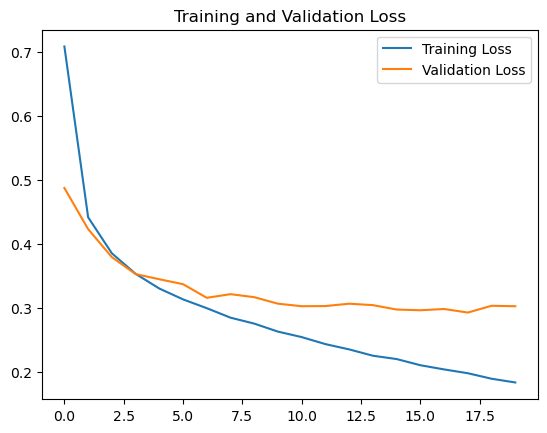

In [25]:
x = range(20)
plt.plot(x, loss_train, label='Training Loss')
plt.plot(x, loss_valid, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

### 6. Show the confusion matrix and accuracy on the test dataset. (Don't do confussion matrix)

In [26]:
def evaluate(model, loader):
    if torch.cuda.is_available():
        model.cuda()

    model.eval()
    correct = 0
    for test_imgs, test_labels in loader:
        if torch.cuda.is_available():
            test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()

        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f} ".format( float(correct) / (len(loader)*100)))

conv_nn.load_state_dict(torch.load('saved_model.pth'))
evaluate(conv_nn, loaders['test'])

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Test accuracy:0.890 


### 7. Is LeNet better than the fully connected Neural Network trained in the project from lecture 3? Comment on the results

### Answer

TODO: We need to look in to how the model in lecture 3 performs on unseen data

The LeNet model that we have implemented seems to be performing well. However, we do not have a direct comparison between this model and the model from lecture 3 since we haven't calculated the accuracy.


## Sub-project 2:

## Use a pretrained model to solve

In this project you will download the Intel Image Classification dataset (https://www.kaggle.com/puneet6060/intel-image-classification/download).
Find a suitable pretrained Convolutional Neural Network and its weights. Fix the filters and retrain/finetune the top of the network. Show and comment on resuls.

Alternativelly, you can browse Kaggle for some interesting datasets like: Dogs vs Cats, Alien vs Predator, Doom vs Animal Crossing, CelebA, etc. Just don't use something easy like MNIST, Fashion-MNIST, etc.

### 1. Download the data

In [31]:

!sh ./setup.sh

5897.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  archive.zip
  inflating: ./data/proj-2/seg_pred/seg_pred/10004.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10005.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10012.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10013.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10017.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10021.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/1003.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10034.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10038.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10040.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10043.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10045.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10047.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10048.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10052.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10054.jpg  
  inflating: ./data/proj-2/seg_pred/seg_pred/10059.jpg  
  inflatin

In [37]:
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
category_to_idx = {cat: idx for idx, cat in enumerate(categories)}
data_dir = './data/proj-2'
train_data_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
test_data_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

def load_data(dir_path):

    result_df = pd.DataFrame(columns=['image', 'label'])

    for category in categories:
        current_path = os.path.join(dir_path, category)

        images = os.listdir(current_path)
        number_of_images = len(images)

        current_df = pd.DataFrame({
            'image': [os.path.join(current_path, img) for img in images],
            'label': [category] * number_of_images
        })

        result_df = pd.concat([result_df, current_df], ignore_index=True)

    return result_df

train_df = load_data(train_data_dir)
test_df = load_data(test_data_dir)

### Creating a dataloader

In [44]:
class IntelDataSet(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None, transform_label=None):
        self.dataframe = dataframe
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = io.read_image(img_path)
        label = category_to_idx[self.dataframe.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

    def get_column_idx(self, column_name):
        return self.dataframe.columns.get_loc(column_name)

image_trans = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ConvertImageDtype(torch.float)
])

dataset = IntelDataSet(train_df, transform=image_trans)
test_dataset = IntelDataSet(test_df, transform=image_trans)

### Show an example of one of the images in the datasets

Image shape: torch.Size([3, 150, 150])
Permuted image shape: (150, 150, 3)
Label: 0


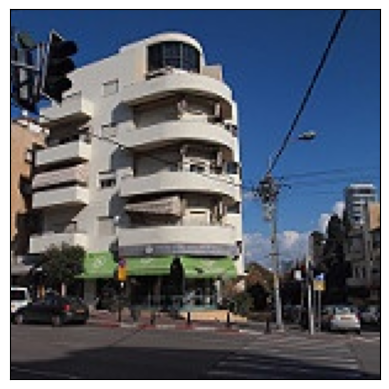

In [45]:
image, label = dataset[1000]
permuted_image = image.permute(1, 2, 0).numpy()

print(f"Image shape: {image.shape}") # Is (Color, height, width) 
print(f"Permuted image shape: {permuted_image.shape}") # Is (height, width, color)
print(f"Label: {label}")

def tensor_to_image(tensor):
    img = plt.imshow(tensor.permute(1, 2, 0).numpy()) 
    plt.axis('on')  # Hide axes
    plt.xticks([])  # Hide x-ticks
    plt.yticks([])  # Hide y-ticks
    
tensor_to_image(image)


### 2. Preprocess the data.

(This might include resizing, augmenting, etc.)




This is done with the above dataset 

### 3. Split the data (train / test / validation) and make mini-batches.

In [73]:
dataset_len = len(dataset)
dataset_test_len = len(test_dataset)
batch_size = 150
print(f"Dataset length: {dataset_len}")
print(f"Test Dataset length: {dataset_test_len}")

dataset_train_len = int(0.9 * dataset_len)
dataset_val_len = dataset_len - dataset_train_len

partition_lengths = [dataset_train_len, dataset_val_len]
print(f"Training set length: {dataset_train_len}, Validation set length: {dataset_val_len}")

dataset_train, dataset_eval = torch.utils.data.random_split(dataset, [dataset_train_len, dataset_val_len])

loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=150,
                                          shuffle=True,
                                          num_workers=0),
    'validation'  : torch.utils.data.DataLoader(dataset_eval, 
                                          batch_size=150,
                                          shuffle=True,
                                          num_workers=0),
    'test'  : torch.utils.data.DataLoader(test_dataset,
                                          batch_size=150,
                                          shuffle=True,
                                          num_workers=0),
}


Dataset length: 14034
Test Dataset length: 3000
Training set length: 12630, Validation set length: 1404


### 4. Download the pretrained architecture and weights.

This part might include some research and understanding of architecures and the type of data they were trained on.

In [47]:
model_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print(f"Model architecture: {model_resnet}")

Model architecture: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

### 5. Build the larger model that includes the pre-trained part and prepare it for training.

* Show the model summary so you are sure which components are included and how many (un)trainable parameters you have

In [63]:
# 
for param in model_resnet.parameters():
    param.requires_grad = False

custom_head = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 256),  # ResNet18 outputs 512 features
    nn.ReLU(),
    nn.Linear(256, len(categories))  # Output layer for the number of classes
)

custom_resnet = nn.Sequential(
    model_resnet.conv1,
    model_resnet.bn1,
    model_resnet.relu,
    model_resnet.maxpool,
    model_resnet.layer1,
    model_resnet.layer2,
    model_resnet.layer3,
    model_resnet.layer4,
    model_resnet.avgpool,
    nn.Flatten(),
    custom_head
)

print(custom_resnet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [64]:
# double-check that everything is how it's supposed to be
# freeze pre-trained network
for name, param in custom_resnet.named_parameters():
    tag = ' ' if param.requires_grad else 'F'
    print(f'[{tag}] {name}')

[F] 0.weight
[F] 1.weight
[F] 1.bias
[F] 4.0.conv1.weight
[F] 4.0.bn1.weight
[F] 4.0.bn1.bias
[F] 4.0.conv2.weight
[F] 4.0.bn2.weight
[F] 4.0.bn2.bias
[F] 4.1.conv1.weight
[F] 4.1.bn1.weight
[F] 4.1.bn1.bias
[F] 4.1.conv2.weight
[F] 4.1.bn2.weight
[F] 4.1.bn2.bias
[F] 5.0.conv1.weight
[F] 5.0.bn1.weight
[F] 5.0.bn1.bias
[F] 5.0.conv2.weight
[F] 5.0.bn2.weight
[F] 5.0.bn2.bias
[F] 5.0.downsample.0.weight
[F] 5.0.downsample.1.weight
[F] 5.0.downsample.1.bias
[F] 5.1.conv1.weight
[F] 5.1.bn1.weight
[F] 5.1.bn1.bias
[F] 5.1.conv2.weight
[F] 5.1.bn2.weight
[F] 5.1.bn2.bias
[F] 6.0.conv1.weight
[F] 6.0.bn1.weight
[F] 6.0.bn1.bias
[F] 6.0.conv2.weight
[F] 6.0.bn2.weight
[F] 6.0.bn2.bias
[F] 6.0.downsample.0.weight
[F] 6.0.downsample.1.weight
[F] 6.0.downsample.1.bias
[F] 6.1.conv1.weight
[F] 6.1.bn1.weight
[F] 6.1.bn1.bias
[F] 6.1.conv2.weight
[F] 6.1.bn2.weight
[F] 6.1.bn2.bias
[F] 7.0.conv1.weight
[F] 7.0.bn1.weight
[F] 7.0.bn1.bias
[F] 7.0.conv2.weight
[F] 7.0.bn2.weight
[F] 7.0.bn2.bias
[

### 6. Train the trainable part of the model

In [65]:
device = None
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")


In [66]:
def training_loop_simple(num_epochs, nn, gpu, loaders, loss_f, optimizer, folder="./"):
    """
    Implements the most basic form of training loop.
    Useful to test specific architectures or optimizers

    Returns:
      - `loss_train`: list of the loss values computed on the training set, for each epoch
      - `loss_valid`: list of the loss values computed on the validation set, for each epoch
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

    loss_train = []
    loss_valid = []
    training_time = []
    min_valid_loss = np.inf

    if not gpu == None:
        nn.to(gpu)

    for epoch in range(num_epochs):
        time_epoch_start = time.time()

        # Train the model
        epoch_train_loss = 0
        # This line tells our NN that it's in the training mode
        # This will become relevant when we introduce layers that behave
        # differently in training and deployment/evaluation modes
        nn.train()

        for i, (images, labels) in tqdm.tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            if not gpu == None:
                images, labels = images.to(gpu), labels.to(gpu)

            output = nn(images)
            loss = loss_f(output, labels)

            epoch_train_loss += loss.item()

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

        # Validate the model
        epoch_val_loss = 0
        nn.eval()
        for i, (images_v, labels_v) in tqdm.tqdm(enumerate(loaders['validation']), total=len(loaders['validation'])):
            if not gpu == None:
                images_v, labels_v = images_v.to(gpu), labels_v.to(gpu)
            output = nn(images_v)
            loss_v = loss_f(output, labels_v)
            epoch_val_loss += loss_v.item()

        time_epoch_end = time.time()
        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
        print('-------------------')

        loss_train.append(epoch_train_loss / len(loaders["train"]))
        loss_valid.append(epoch_val_loss / len(loaders["validation"]))
        training_time.append(time_epoch_end-time_epoch_start)

        with open(os.path.join(folder, 'training_stats.json'), 'w') as outfile:
            json.dump(
                {'loss_train': loss_train, 'loss_valid': loss_valid, 'training_time': training_time},
                outfile,
            )

        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
            # Saving State Dict
            torch.save(nn.state_dict(), os.path.join(folder, 'saved_model.pth'))

    return loss_train, loss_valid


In [67]:
num_epochs = 20
if torch.backends.mps.is_available():
    custom_resnet.to(device)

train_loss, valid_loss = training_loop_simple(
    num_epochs=num_epochs,
    nn=custom_resnet,
    gpu=device,
    loaders=loaders,
    loss_f=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(custom_resnet.parameters(), lr=0.001),
    folder="results"
)

100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch 1
Training Loss: 0.5033945399172166
Validation Loss: 0.3844110667705536
-------------------
Validation Loss Decreased(inf--->3.844110667705536) 	 Saving The Model


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Epoch 2
Training Loss: 0.3076031216803719
Validation Loss: 0.3357634723186493
-------------------
Validation Loss Decreased(3.844110667705536--->3.357634723186493) 	 Saving The Model


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch 3
Training Loss: 0.2872723100816502
Validation Loss: 0.3532737895846367
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Epoch 4
Training Loss: 0.27493102287544924
Validation Loss: 0.3091354534029961
-------------------
Validation Loss Decreased(3.357634723186493--->3.0913545340299606) 	 Saving The Model


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 5
Training Loss: 0.25461747330777784
Validation Loss: 0.3499328657984734
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch 6
Training Loss: 0.24772131723516128
Validation Loss: 0.3124070316553116
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch 7
Training Loss: 0.22711044655126683
Validation Loss: 0.33533292859792707
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch 8
Training Loss: 0.22270806002266266
Validation Loss: 0.34068714678287504
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch 9
Training Loss: 0.22128442639813703
Validation Loss: 0.3126446433365345
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch 10
Training Loss: 0.2008969454204335
Validation Loss: 0.3145641803741455
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch 11
Training Loss: 0.1847862399676267
Validation Loss: 0.3160925030708313
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch 12
Training Loss: 0.17955191635033663
Validation Loss: 0.3227635622024536
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch 13
Training Loss: 0.16444485853700078
Validation Loss: 0.3244570270180702
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch 14
Training Loss: 0.15520304607994417
Validation Loss: 0.3272827908396721
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Epoch 15
Training Loss: 0.14699905006324543
Validation Loss: 0.32913153022527697
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch 16
Training Loss: 0.1289228949476691
Validation Loss: 0.34441912919282913
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 17
Training Loss: 0.13069338886176837
Validation Loss: 0.3488321632146835
-------------------


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Epoch 18
Training Loss: 0.10894313529133796
Validation Loss: 0.37631004452705386
-------------------


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch 19
Training Loss: 0.09863312091020977
Validation Loss: 0.35072769075632093
-------------------


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

Epoch 20
Training Loss: 0.09683243875556133
Validation Loss: 0.36717307269573213
-------------------


### 7. Show the training plots and confusion matrix

Text(0.5, 1.0, 'Training and Validation Loss')

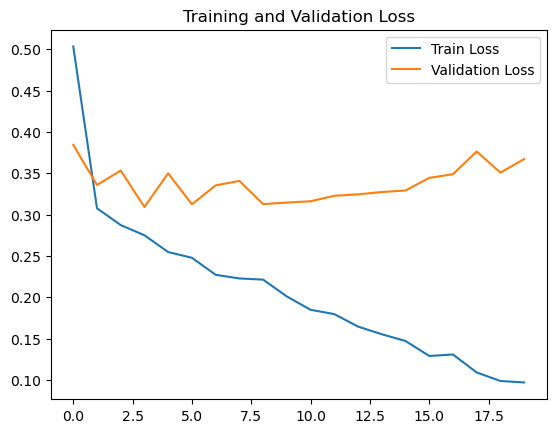

In [68]:
epochs = range(num_epochs)

plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, valid_loss, label="Validation Loss")

plt.legend()
plt.title("Training and Validation Loss")

### Finetune the model and show the plots, test data confusion matrix and accuracy.

In [74]:
def evaluate(model, loader, gpu=None):

    model.eval()
    correct = 0
    for test_imgs, test_labels in loader:
        if not gpu == None:
            test_imgs, test_labels = test_imgs.to(gpu), test_labels.to(gpu)

        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f} ".format( float(correct) / (len(loader)*batch_size)))
    print(f"Correct: {correct}/{len(loader)*batch_size}")

custom_resnet.load_state_dict(torch.load('results/saved_model.pth'))
evaluate(custom_resnet, loaders['test'], device)

Test accuracy:0.900 
Correct: 2701/3000


### 9. Comment on the results. Are the results to your satisfaction? Which phase contributed to the improved performance? What was the most challenging aspect of the exercise? Ideas for improving the model?

Answer: